### **Load Data**

In [1]:
import pandas as pd

# Function to load data from csv file 
def load_data(df):
    return pd.read_csv(file_path)

file_path='../data/flight_df.csv' # The period indicates how many levels (from root, go out of notebooks and then go in data)

# Load the dataset
df=load_data(file_path)
df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split 

# Define target and features 
y=df['satisfied']
X=df.drop(columns='satisfied')

# Split the dataset intro train and tests sets
X_train, X_test, y_train, y_test=train_test_split (X,y, test_size=0.2, random_state=42)

# Check for the class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Create preprocessing pipeline
def create_preprocessing_pipeline():

    # Select numeric and categorical columns
    num_cols=make_column_selector(dtype_include='number')
    cat_cols=make_column_selector(dtype_include='object')

    # Instatiate the transformers
    scaler=StandardScaler()
    ohe=OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    knn_imputer=KNNImputer(n_neighbors=2, weights='uniform')

    # Create the pipeline
    num_pipe=Pipeline([
        ('imputer', knn_imputer),
        ('scaler', scaler)
    ])

    cat_pipe=Pipeline([
        ('encoder', ohe)
    ])

    preprocessor=ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ])

    return preprocessor

# Create preprocessor object
preprocessor=create_preprocessing_pipeline()

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def make_sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler', sampler)
    ]) 

# Preprocess and rebalance data 
def preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train):

    # Transform training data into fitted transformer
    X_train_transformed=preprocessor.fit_transform(X_train)
    X_test_tranformed=preprocessor.transform(X_test)

    # Create sampling pipeline
    sampler=make_sampler_pipeline(SMOTE(random_state=42))

    # Balance training data
    X_train_balanced, y_train_balanced=sampler.fit_resample(X_train_transformed, y_train)

    return X_train_balanced, X_test_tranformed, y_train_balanced

# Preprocess and rebalance the data
X_train_balanced, X_test_tranformed, y_train_balanced=preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

In [5]:
# Convert preprocessed data back into a dataframe
X_train_balanced_df=pd.DataFrame(X_train_balanced)
X_test_tranformed_df=pd.DataFrame(X_test_tranformed)

### **Machine Learning**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import(
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

# Evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):

    # Create predictions on the training set
    train_preds=np.rint(model.predict(X_train)) # np.rint = Round to the nearest INTeger
    test_preds=np.rint(model.predict(X_test))

    # Classification report
    train_report=classification_report(y_train, train_preds)
    test_report=classification_report(y_test, test_preds)

    # Confusion matrix
    cm_train=confusion_matrix(y_train, train_preds)
    cm_test=confusion_matrix(y_test, test_preds)

    # Format 
    plt.style.use('dark_background')

    # Plot training summary and confusion matrix side-by-side
    fig, axes=plt.subplots(1,2, figsize=(14,5))
    # First axes
    axes[0].text(0.01, 0.05, str(train_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes 
    disp_train=ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[0].set_title('Confusion Matrix - Training Set')

    # Plot test summary and confusion matrix side-by-side
    fig, axes=plt.subplots(1,2, figsize=(14,5))
    # First axes
    axes[0].text(0.01, 0.05, str(test_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes 
    disp_test=ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Confusion Matrix - Testing Set')

    plt.show()

    return train_report, test_report


In [7]:
from sklearn.pipeline import Pipeline

# Create ML pipeline 
def train_and_predict_model(X_train, y_train, X_test, preprocessor, model):

    # Combine preprocessing pipeline and model
    model_pipe=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model),
    ])

    # Fit the pipeline on the training data
    model_pipe.fit(X_train, y_train)

    # Save predictions
    train_preds=model_pipe.predict(X_train)
    test_preds=model_pipe.predict(X_test)

    return train_preds, test_preds

In [8]:
import lightgbm as lgb

# Instantiate the model
lgbm_model=lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create predictions 
train_preds, test_preds=train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_tranformed_df, preprocessor, lgbm_model)

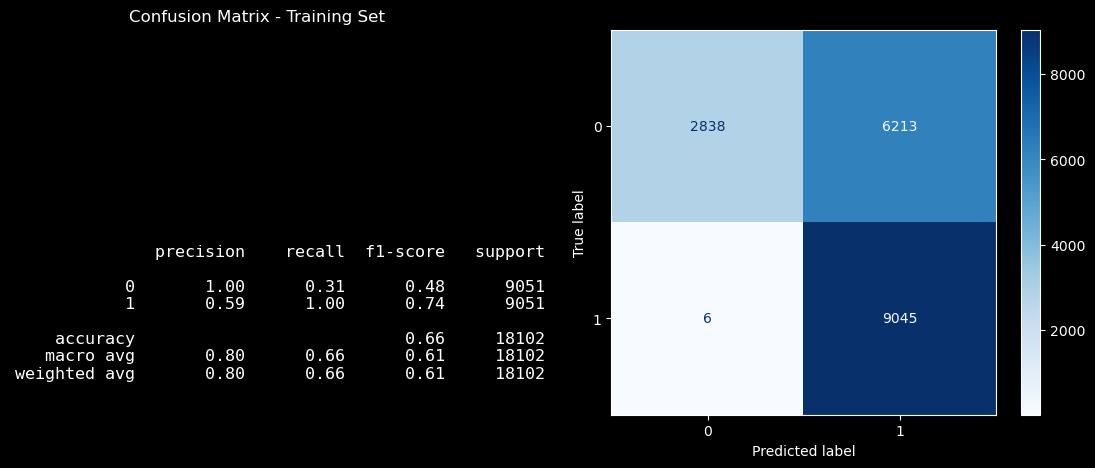

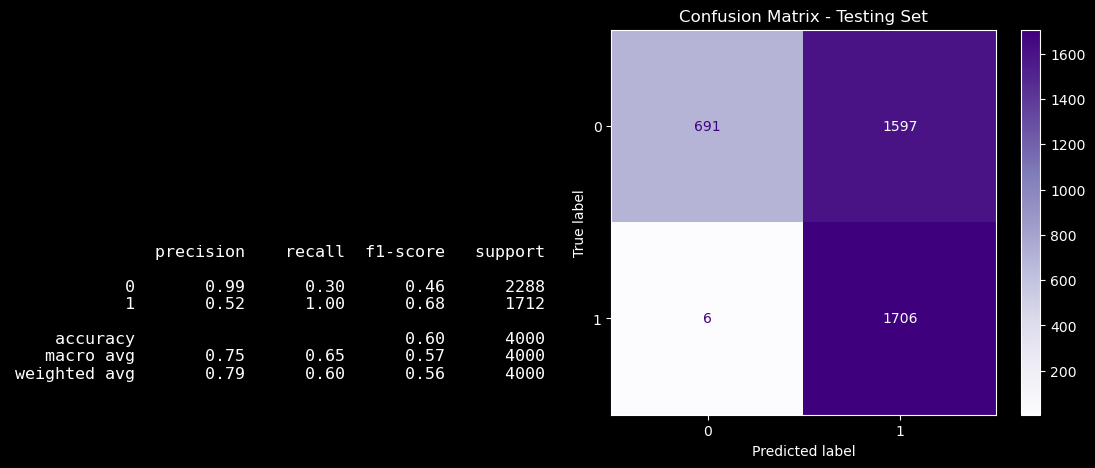

In [9]:
#  Return the train and test reports
train_report, test_report=evaluate_model(lgbm_model, X_train_balanced_df, y_train_balanced, X_test_tranformed_df, y_test)

**F1 Score - Training Set**

- **Definition:** The F1 score is the harmonic mean of precision and recall, providing a balance between the two.
- **Purpose:** It is useful for evaluating performance, especially when class distribution is uneven.
- **Example Value:** If the training set F1 score is 0.95, it indicates strong performance on known data, balancing precision and recall.

**F1 Score - Testing Set**

- **Example Value:** If the testing set F1 score is 0.89, it suggests slightly reduced performance compared to the training set.
- **Implication:** A lower F1 score on the testing set might reflect greater difficulty in accurately predicting unseen data, possibly indicating overfitting if the gap is large.

**Comparison**

- **Significance of the Difference:**
  - **Small Difference:** Indicates good generalization from training to testing data.
  - **Large Difference:** May suggest overfitting, where the model performs well on training data but poorly on new data.

By focusing on F1 scores, you can assess how well your model balances precision and recall across both training and testing sets, providing insights into its robustness and potential overfitting. 


In [10]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the DecisionTreeClassifier
dec_tree=DecisionTreeClassifier()

# Create predictions 
train_preds, test_preds=train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_tranformed_df, preprocessor, dec_tree)

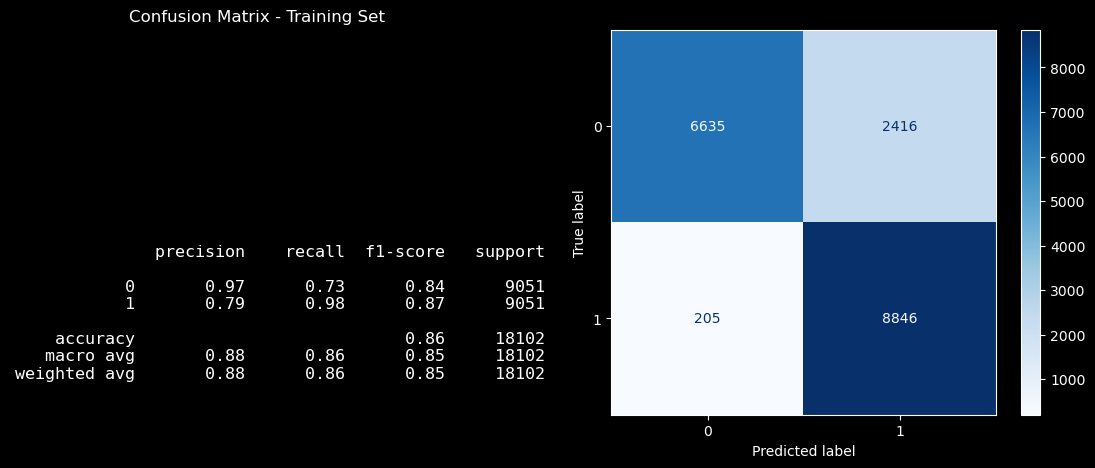

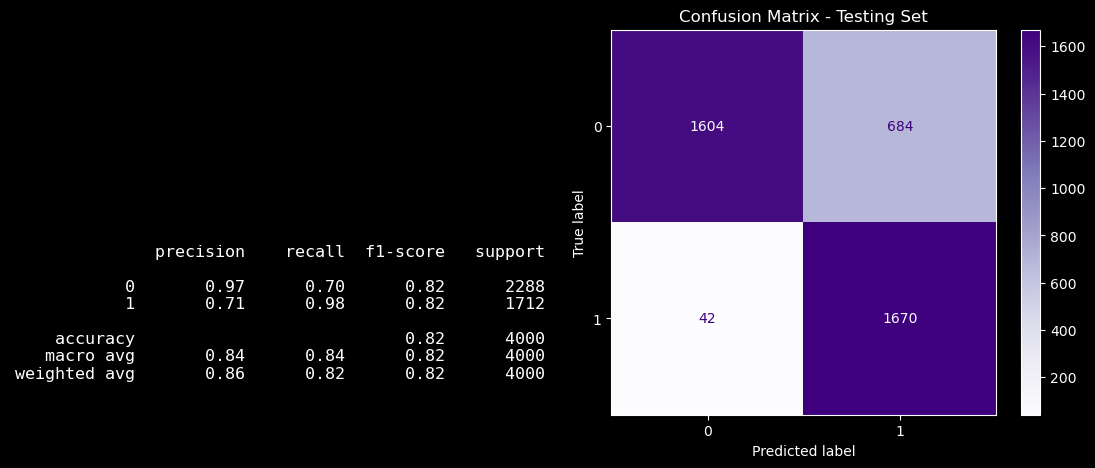

In [11]:
#  Return the train and test reports
train_report, test_report=evaluate_model(dec_tree, X_train_balanced_df, y_train_balanced, X_test_tranformed_df, y_test)

**F1 Score - Training Set**

- **Class 0 F1 Score:** 0.99
- **Class 1 F1 Score:** 0.83
- **Interpretation:** 
  - The F1 score for Class 0 is very high, indicating excellent performance with little trade-off between precision and recall.
  - The F1 score for Class 1 is lower, suggesting more room for improvement in balance between precision and recall, but still relatively strong.

**F1 Score - Testing Set**

- **Class 0 F1 Score:** 0.99
- **Class 1 F1 Score:** 0.82
- **Interpretation:** 
  - Similar high performance for Class 0 as the training set, indicating consistent performance.
  - Slight decrease in F1 score for Class 1 compared to the training set, reflecting some challenges when predicting new data.

**Comparison**

- **Consistency:**
  - The F1 scores are mostly consistent between the training and testing sets, with only a slight drop for Class 1.
  - This suggests good generalization from the training data to the test data.

- **Implication:**
  - A small difference between the training and testing F1 scores indicates the model is not significantly overfitting.

The consistent F1 scores across training and testing sets demonstrate that the model performs well overall, maintaining a balance between precision and recall.


### **Model Evaluation**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility 
np.random.seed(42)

# Train the model 
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Get feature importance
def get_feature_importance (model, feature_names):

    importance=model.feature_importances_

    feature_importance= pd.DataFrame({
        'feature' : feature_names,
        'importance' : importance
    }).sort_values (by='importance', ascending=False)

    return feature_importance

# Plot the features 
def plot_feature_importance(feature_importance, title):

    plt.figure(figsize=(10,6))

    # Barplot
    sns.barplot(
        x='importance',
        y='feature', 
        data=feature_importance,
        palette='viridis',
        hue='feature'
    )

    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

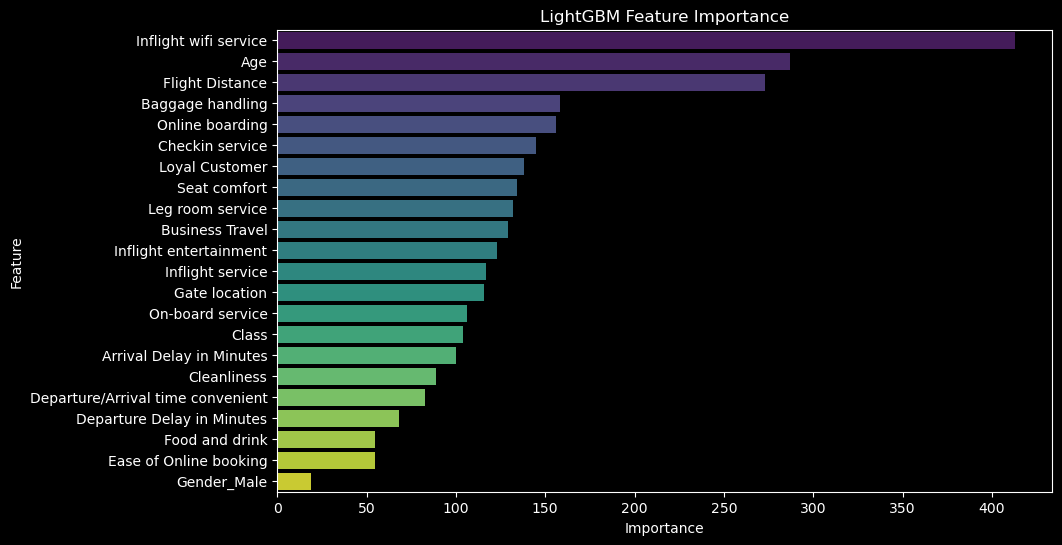

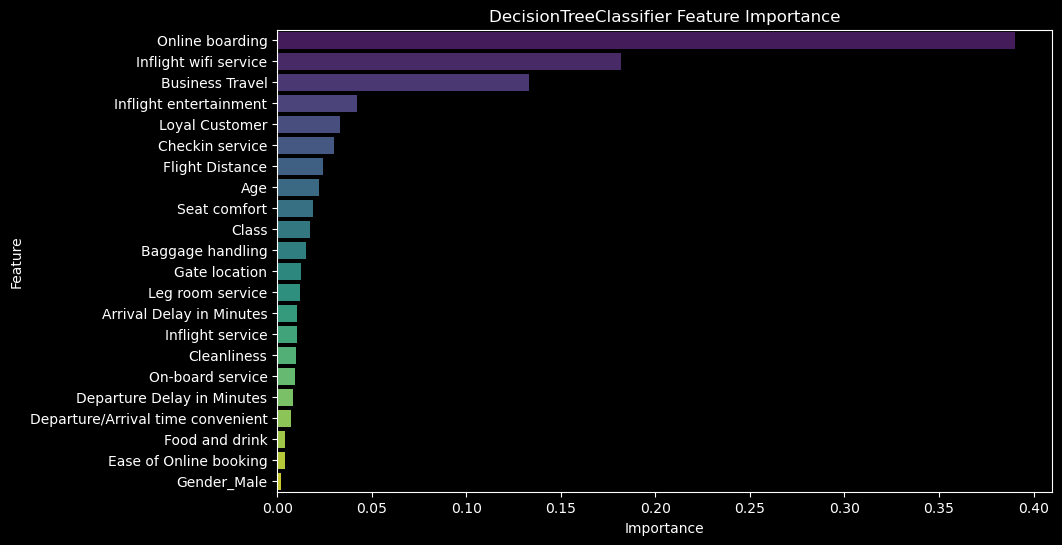

In [13]:
# Get feature names
feature_names = X_train.columns

# Train LGBMClassifier
trained_lgbm_model= train_model(lgbm_model, X_train_balanced, y_train_balanced)

# Get and plot feature importances of the LGBM classifier
lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# Train DecisionTreeClassifier
trained_dec_tree= train_model(dec_tree, X_train_balanced, y_train_balanced)

# Get and plot feature importances of the DecisionTreeClassifier
dec_tree_feature_importance = get_feature_importance(trained_dec_tree, feature_names)
plot_feature_importance(dec_tree_feature_importance, title='DecisionTreeClassifier Feature Importance')

**The top features common to both models for input in Streamlit App:**

1. Inflight wifi service
2. Online boarding
3. Business Travel
4. Inflight entertainment
5. Loyal Customer
6. Checkin service
7. Flight Distance
8. Age
9. Seat comfort
10. Class

### Hyperparameter Tuning and GridSearchCV

In [21]:
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score)

# Evaluate metrics
def evaluate_classification(y_true, y_pred):
    accuracy= accuracy_score (y_true, y_pred)
    recall= recall_score(y_true, y_pred)
    precision= precision_score (y_true, y_pred)
    f1= f1_score (y_true, y_pred)

    return accuracy, recall, precision, f1

In [30]:
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

# Setup hyperparameters for the grid search 
models = {
    'LightGBM' : lgb.LGBMClassifier(verbose=-1),
    'DecisionTree' : DecisionTreeClassifier()
}

# Define parameters
param_grids = {
    'LightGBM' : {
        'classifier__n_estimators' : [50, 100, 200],
        'classifier__learning_rate' : [0.01, 0.1, 1.0]
    },
    'DecisionTree': {
        'classifier__max_depth' : [None, 10, 20],
        'classifier__min_samples_split' : [2, 5, 7]
    }
}

In [38]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV

# Train and evaluate the models
def train_and_evaluate_models (X_train, y_train, X_test, y_test):
    metrics_list = []
    best_models = {}

    for model_name, model in tqdm(models.items(), desc = 'Training Models'):
        model_pipe = Pipeline (steps=[
            ('classifier', model)
        ])

        grid_search = GridSearchCV (estimator = model_pipe,
                                    param_grid = param_grids [model_name],
                                    cv = 5,
                                    n_jobs = -1,
                                    scoring = 'f1_weighted'
                                    )
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_models [model_name] = best_model

        # Predictions
        train_pred = best_model.predict (X_train)
        test_pred = best_model.predict (X_test)

        # Evaluate the classification
        train_accuracy, train_recall, train_precision, train_f1 = evaluate_classification (y_train, train_pred)
        test_accuracy, test_recall, test_precision, test_f1 = evaluate_classification (y_test, test_pred)

        # Save metrics
        row = {
            'Model' : model_name, 
            'Train Accuracy' : train_accuracy,
            'Train Recall' : train_recall,
            'Train Precision' : train_precision,
            'Train F1 Score': train_f1,
            'Test Accuracy' : test_accuracy,
            'Test Recall' : test_recall,
            'Test Precision' : test_precision,
            'Test F1 Score': test_f1
        }

        metrics_list.append(row)

        # Convert metrics list into a DataFrame
        metrics_df = pd.DataFrame(metrics_list)

    return metrics_df, best_models

In [39]:
# Train and test the models
metrics_df, best_models = train_and_evaluate_models (X_train_balanced, y_train_balanced, X_test_tranformed, y_test)
metrics_df

Training Models: 100%|██████████| 2/2 [00:37<00:00, 18.97s/it]


,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,LightGBM,0.995304,0.994255,0.996346,0.995299,0.95675,0.936916,0.961055,0.948832
1,DecisionTree,0.959949,0.951276,0.968068,0.959599,0.92775,0.908879,0.921255,0.915025


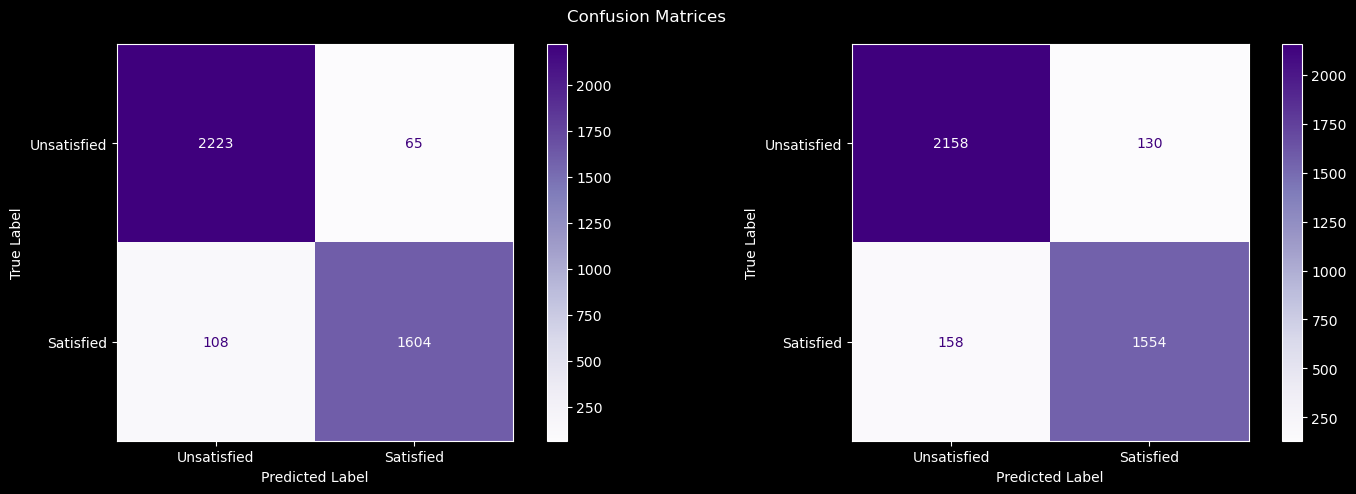

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Display confusion matrices
def plot_confusion_matrix (best_models, X_test, y_test):
    labels = ['Unsatisfied', 'Satisfied']
    fig, axes = plt.subplots (1, len(best_models), figsize = (15,5))

    for ax, (model_name, model) in zip (axes, best_models.items()): 
        
        # Predict the test set 
        test_pred = model.predict(X_test)

        # Confusion matrix 
        cm = confusion_matrix (y_test, test_pred)

        # Display the confusion matrix
        disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels= labels)
        disp.plot (cmap = 'Purples', ax = ax, values_format= 'd')
        ax.set_title = (f'{model_name}')
        ax.set_xlabel ('Predicted Label')
        ax.set_ylabel ('True Label')

    plt.suptitle ('Confusion Matrices')
    plt.tight_layout()
    plt.show()

# Display confusion matrices
plot_confusion_matrix (best_models, X_test_tranformed, y_test)

**Confusion Matrix Comparison: LightGBM vs Decision Tree**

- **LightGBM (Left Matrix)**
  - **True Positives (Satisfied predicted as Satisfied)**: 1604
  - **True Negatives (Unsatisfied predicted as Unsatisfied)**: 2223
  - **False Positives (Unsatisfied predicted as Satisfied)**: 65
  - **False Negatives (Satisfied predicted as Unsatisfied)**: 108
  
  LightGBM performed well, with only 65 false positives and 108 false negatives, indicating that it predicted the majority of satisfied and unsatisfied customers accurately.

- **Decision Tree (Right Matrix)**
  - **True Positives (Satisfied predicted as Satisfied)**: 1554
  - **True Negatives (Unsatisfied predicted as Unsatisfied)**: 2158
  - **False Positives (Unsatisfied predicted as Satisfied)**: 130
  - **False Negatives (Satisfied predicted as Unsatisfied)**: 158
  
  The Decision Tree model had slightly more false positives (130) and false negatives (158) compared to LightGBM, suggesting it was less effective at distinguishing between satisfied and unsatisfied customers.


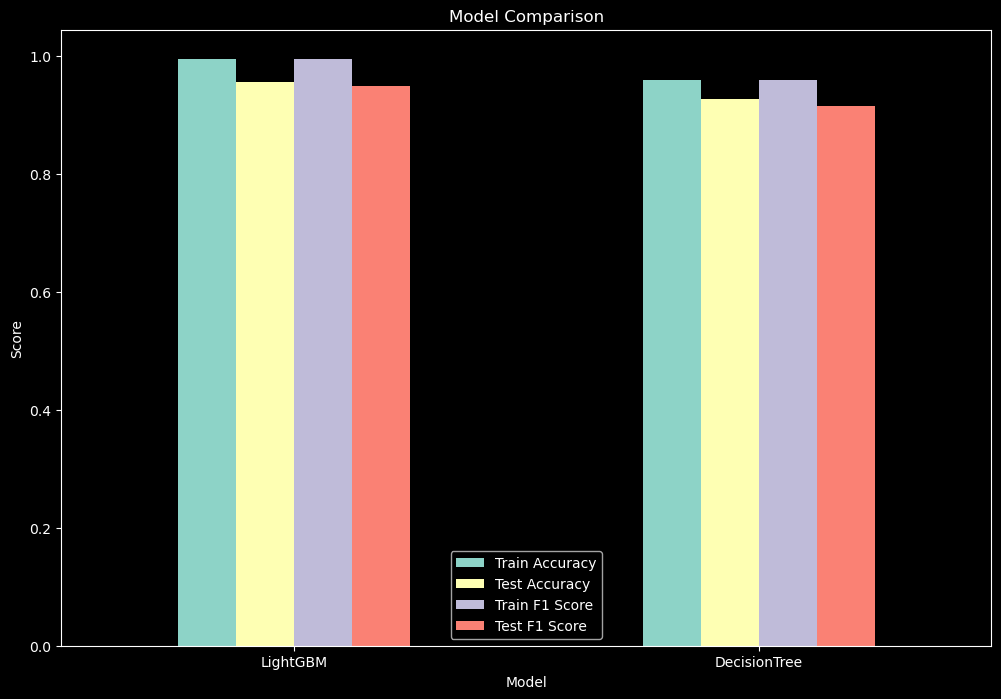

In [41]:
# Display evaluation as a chart
def display_evaluation_matrix (metrics_df):
    metrics_df.set_index('Model')[[
        'Train Accuracy',
        'Test Accuracy',
        'Train F1 Score',
        'Test F1 Score'
    ]].plot (kind = 'bar', figsize = (12,8))

    plt.title ('Model Comparison')
    plt.xlabel ('Model')
    plt.ylabel ('Score')
    plt.xticks (rotation = 0)
    plt.legend (loc = 'best')
    plt.show()

# Display comparison chart
display_evaluation_matrix (metrics_df)

**Model Comparison: LightGBM vs Decision Tree**

- **LightGBM:**
  - **Train Accuracy:** High, close to 1.0, indicating the model fits the training data well.
  - **Test Accuracy:** Slightly lower than train accuracy, but still very high, suggesting good generalization.
  - **Train F1 Score:** Close to 1.0, indicating a strong ability to balance precision and recall on the training data.
  - **Test F1 Score:** Slightly lower than the training F1 score but still high, demonstrating good performance on unseen data.

- **Decision Tree:**
  - **Train Accuracy:** Nearly identical to LightGBM, showing a strong fit to the training data.
  - **Test Accuracy:** Similar to LightGBM, with a minor decrease compared to training accuracy, indicating generalization but slightly less robust.
  - **Train F1 Score:** High, like LightGBM, indicating good precision and recall for the training set.
  - **Test F1 Score:** Slightly lower than the training F1 score, performing almost similarly to LightGBM but marginally less effective in generalization.

**Conclusion:**
Both models perform very well with near-perfect train and test accuracy, and high F1 scores. LightGBM has a slight edge over the Decision Tree in terms of F1 score on the test set, suggesting it handles generalization a bit better.


Learning Curve for LightGBM


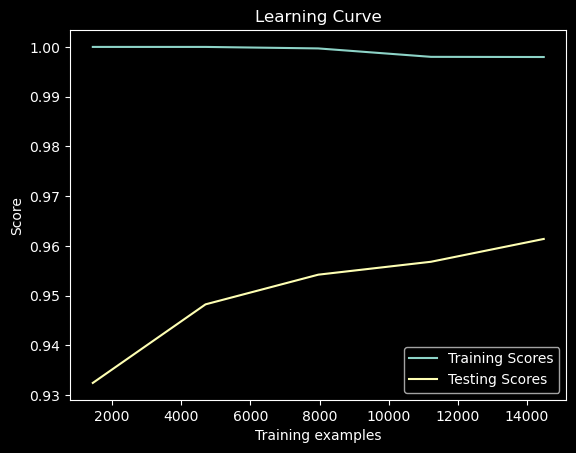

Learning Curve for DecisionTree


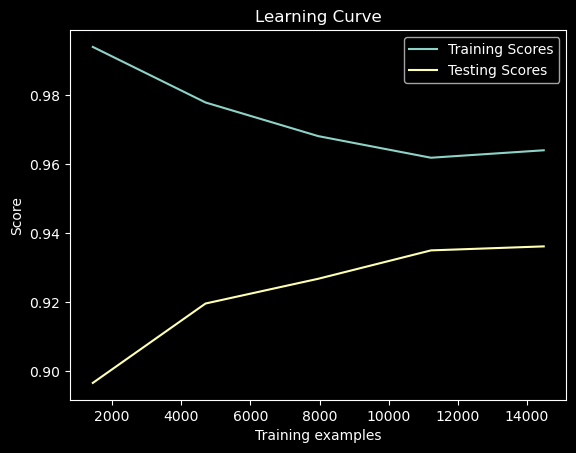

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Learning curves
def plot_learning_curves (estimator, X, y, scoring):

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv = 5, 
        train_sizes = np.linspace (0.1, 1.0, 5),
        scoring = scoring
    )

    train_scores_mean = np.mean (train_scores, axis = 1)
    test_scores_mean = np.mean (test_scores, axis = 1)

    plt.plot (train_sizes, train_scores_mean, label = 'Training Scores')
    plt.plot (train_sizes, test_scores_mean, label = 'Testing Scores')

    plt.title ('Learning Curve')
    plt.xlabel ('Training examples')
    plt.ylabel ('Score')
    plt.legend (loc = 'best')
    plt.grid (False)
    plt.show()

# Call the function as a loop
for model_name, best_model in best_models.items():
    print (f'Learning Curve for {model_name}')
    plot_learning_curves(best_model, X_train_balanced, y_train_balanced, scoring = 'accuracy')

**LGBM Model**
- **Training Score:** 
  - Shows improvement as more samples are added, with the score increasing.
- **Testing Score:** 
  - Also improves but at a slower rate compared to training performance.

**Decision Tree Model**
- **Training Score:** 
  - Decreases as more samples are introduced, eventually stabilizing.
- **Testing Score:** 
  - Increases slightly and then stabilizes, indicating generalization to unseen data.

Overall, with increased training data, the performance of both models becomes more stable and their ability to generalize improves. However the the LGBM model may show a more consistent improvement across the dataset. 
